In [1]:
print("""
@File         : ch08_accounting_for_seasonality.ipynb
@Author(s)    : Stephen CUI
@LastEditor(s): Stephen CUI
@CreatedTime  : 2024-03-28 21:12:06
@Email        : cuixuanstephen@gmail.com
@Description  : 考虑季节性因子
""")


@File         : ch08_accounting_for_seasonality.ipynb
@Author(s)    : Stephen CUI
@LastEditor(s): Stephen CUI
@CreatedTime  : 2024-03-28 21:12:06
@Email        : cuixuanstephen@gmail.com
@Description  : 考虑季节性因子



In [2]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm.notebook import tqdm
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

## Examining the $SARIMA(p,d,q)(P,D,Q)_m$ model

参数 $m$ 代表频率。在时间序列的背景下，频率定义为每个周期的观测数。对于每年、每季度、每月或每周记录的数据，一个周期的长度可以被视为 1 年。如果数据每年记录一次，则 $m = 1$，因为每年只有一次观察。如果数据按季度记录，则 $m = 4$，因为一年有四个季度，因此每年有四个观测值。当然，如果数据是每月记录的，则 $m = 12$。最后，对于每周数据，$m = 52$。**主要是季节性因子的长度内有多少条观测数据**

|Data |collection|
|----|----|
|Frequency |m|
|Annual |1|
|Quarterly |4|
|Monthly |12|
|Weekly |52|

当每天或次日收集数据时，有多种解释频率的方法。例如，每日数据可以具有每周季节性。在这种情况下，频率为 $m = 7$，因为在 1 周的完整周期内将有 7 个观测值。它还可能具有每年的季节性，这意味着 $m = 365$。因此，您可以看到每日和次每日数据可以具有不同的周期长度，因此具有不同的频率 $m$。

|Data collection|Frequency m|||||
|----|----|----|----|----|----|
||Minute|Hour|Day|Week|Year
Daily||||7|365
Hourly|||24|168|8766
Every minute||60|1440|10080|525960
Every second|60|3600|86400|604800|31557600

**Seasonal autoregressive integrated moving average (SARIMA) model**

The seasonal autoregressive integrated moving average (SARIMA) model adds seasonal parameters to the ARIMA(p,d,q) model. It is denoted as SARIMA(p,d,q)(P,D,Q)m, where P is the order of the seasonal AR(P) process, D is the seasonal order of integration, Q is the order of the seasonal MA(Q) process, and m is the frequency, or the number of observations per seasonal cycle. Note that a SARIMA(p,d,q)(0,0,0)m model is equivalent to an ARIMA(p,d,q) model.

让我们考虑一个 $m = 12$ 的示例。如果 $P = 2$，这意味着我们以 $m$ 倍数的滞后值包含该序列的两个过去值。因此，我们将包含 $y_t – 12$ 和 $y_t – 24$ 处的值。

同样，如果 $D = 1$，这意味着季节性差异使序列平稳

$$y_t^{'} = y_t – y_{t–12}$$

在 $Q = 2$ 的情况下，我们将包含 $m$ 倍数滞后的过去误差项。因此，我们将包含误差 $\epsilon_{t–12}$ 和 $\epsilon_{t–24}$。

In [3]:
df = pd.read_csv('../data/air-passengers.csv')
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


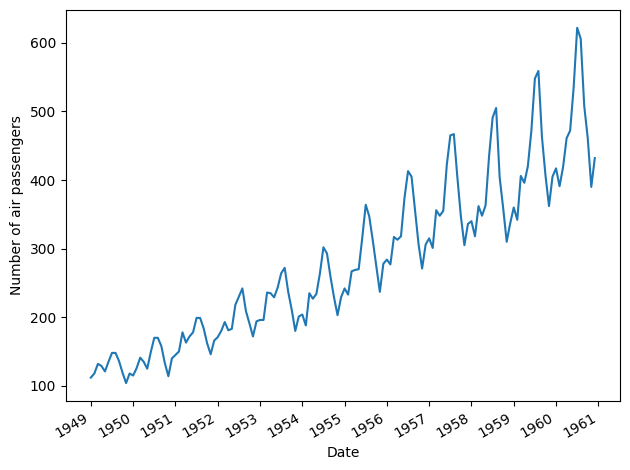

In [4]:
fig, ax = plt.subplots()
ax.plot(df['Month'], df['Passengers'])
ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers')

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH08_F01.png', dpi=300)

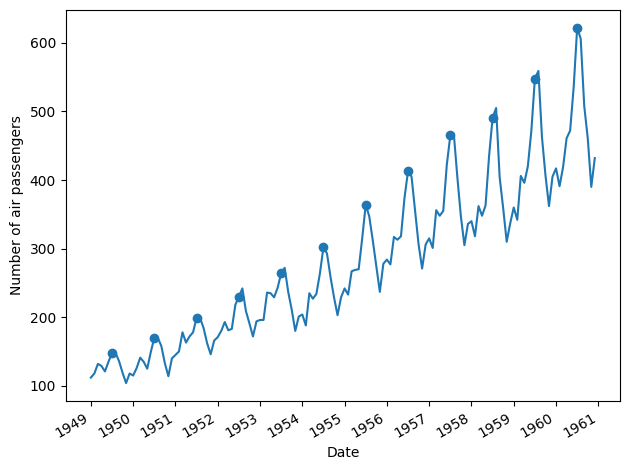

In [5]:
fig, ax = plt.subplots()

ax.plot(df['Month'], df['Passengers'], markevery=np.arange(6, 145, 12), marker='o')
ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers')

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH08_F02_peixeiro.png', dpi=300)

## 识别时间序列中的季节性模式

通常，绘制时间序列数据足以观察周期性模式。

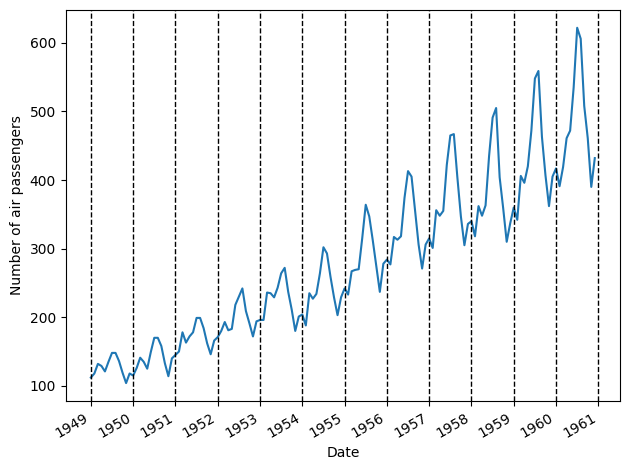

In [6]:
fig, ax = plt.subplots()

ax.plot(df['Month'], df['Passengers'])
for i in np.arange(0, 145, 12):
    ax.axvline(x=i, linestyle='--', color='black', linewidth=1)
ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers')

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH08_F03.png', dpi=300)

识别时间序列中季节性模式的另一种方法是使用时间序列分解。

**时间序列分解**

时间序列分解是一项统计任务，它将时间序列分为三个主要组成部分：趋势成分、季节性成分和残差。

趋势成分代表时间序列的长期变化，该部分负责随时间增加或减少的时间序列。季节性成分是时间序列中的周期性模式，它代表在固定时间内发生的重复波动。最后，残差或噪声表示无法用趋势或季节性成分解释的任何不规则性。

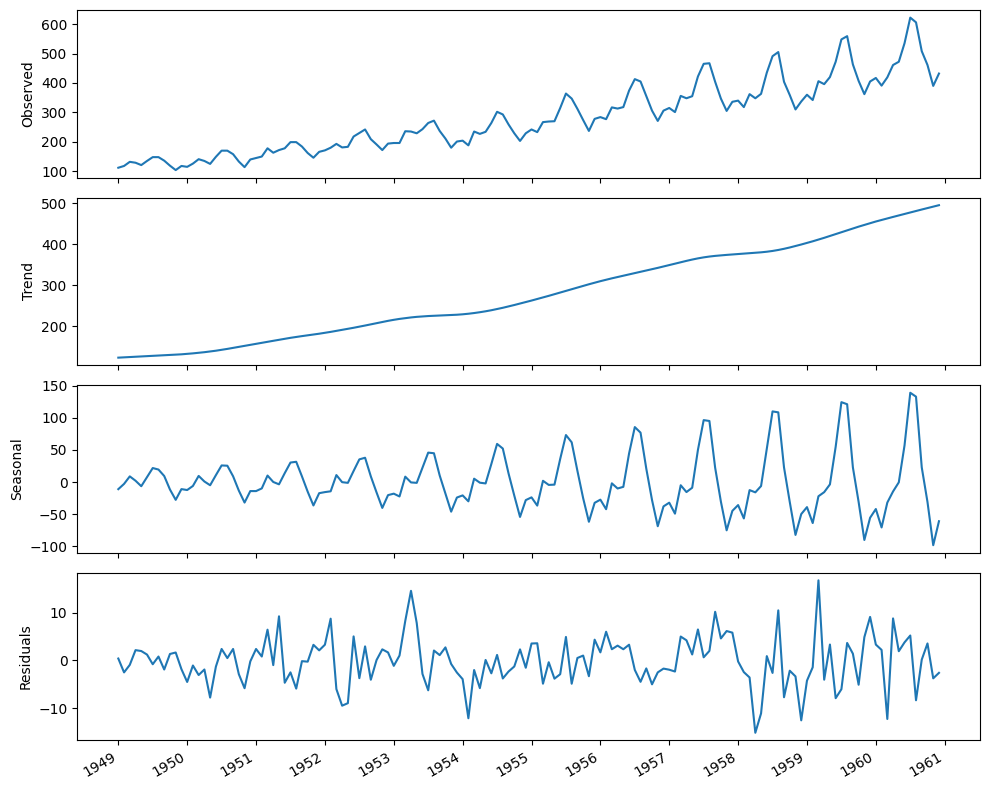

In [7]:
decompositions = STL(df['Passengers'], period=12).fit()

fig, axes = plt.subplots(4, 1, sharex=True, figsize=(10, 8))
axes[0].plot(decompositions.observed)
axes[0].set_ylabel('Observed')
axes[1].plot(decompositions.trend)
axes[1].set_ylabel('Trend')
axes[2].plot(decompositions.seasonal)
axes[2].set_ylabel('Seasonal')
axes[3].plot(decompositions.resid)
axes[3].set_ylabel('Residuals')
plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))
fig.autofmt_xdate()
plt.tight_layout()

在我们的时间序列没有季节性模式的情况下，分解过程将在 0 处显示季节性分量的水平线。

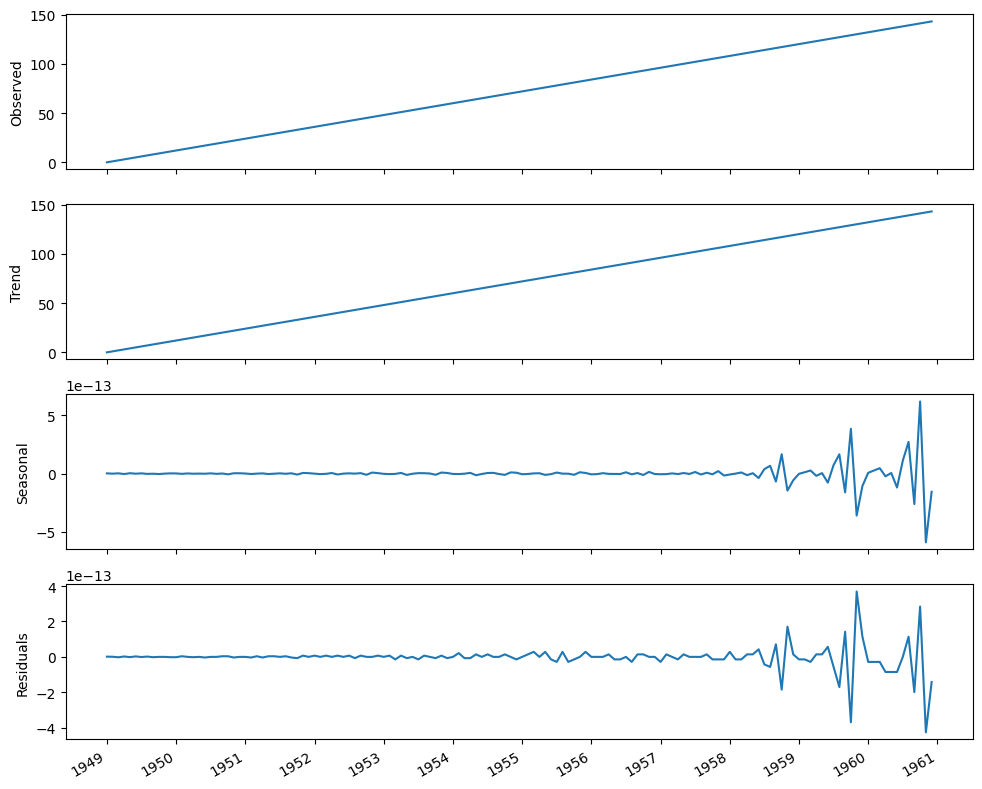

In [8]:
linear_ts = np.arange(0, 144)
decomposition = STL(linear_ts, period=12).fit()
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(10, 8))
axes[0].plot(decomposition.observed)
axes[0].set_ylabel('Observed')
axes[1].plot(decomposition.trend)
axes[1].set_ylabel('Trend')
axes[2].plot(decomposition.seasonal)
axes[2].set_ylabel('Seasonal')
axes[3].plot(decomposition.resid)
axes[3].set_ylabel('Residuals')
plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))
fig.autofmt_xdate()
plt.tight_layout()
plt.savefig('figures/CH08_F05.png', dpi=300)

In [9]:
np.allclose(decomposition.seasonal, 0)

True

随机加点扰动，发现竟然可以识别出季节模型，这不太合理

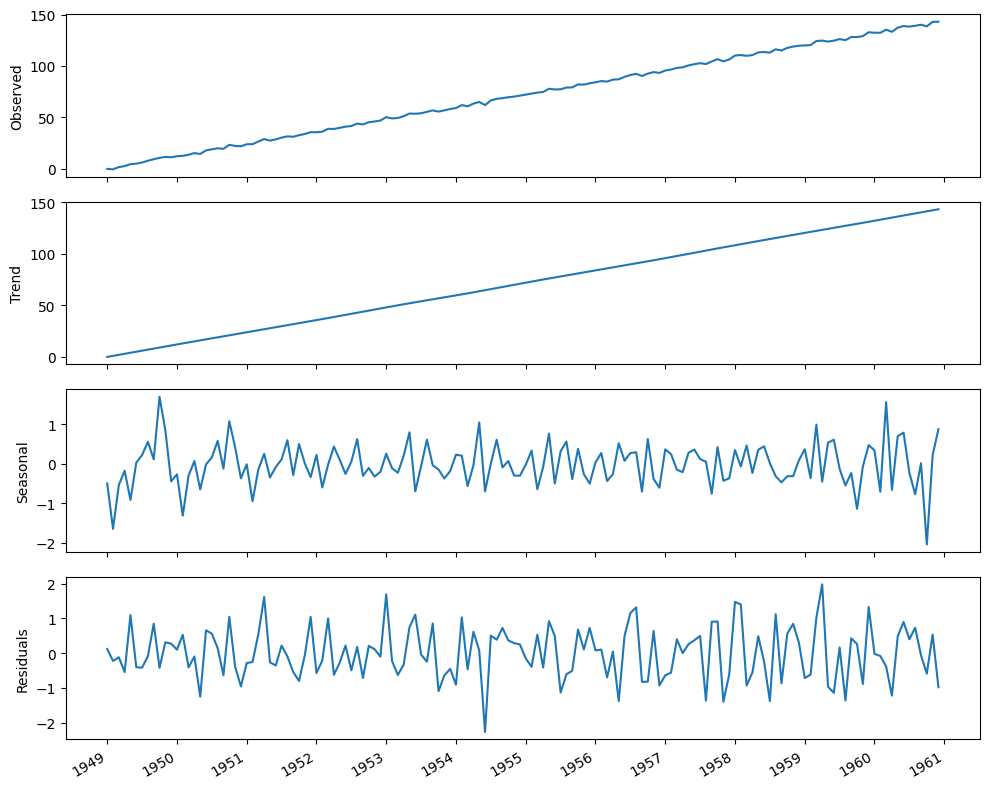

In [10]:
linear_ts = np.arange(0, 144) + np.random.standard_normal(144)
decomposition = STL(linear_ts, period=12).fit()
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(10, 8))
axes[0].plot(decomposition.observed)
axes[0].set_ylabel('Observed')
axes[1].plot(decomposition.trend)
axes[1].set_ylabel('Trend')
axes[2].plot(decomposition.seasonal)
axes[2].set_ylabel('Seasonal')
axes[3].plot(decomposition.resid)
axes[3].set_ylabel('Residuals')
plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))
fig.autofmt_xdate()
plt.tight_layout()

## 利用季节性模式来进行预测

第一步是收集数据。然后我们仍然检查平稳性并应用变换来设置参数 $d$。然而，我们也可以执行季节差分来使序列平稳，并且 $D$ 将等于我们应用季节差分的最小次数。

然后我们为 $p$、$q$、$P$ 和 $Q$ 设置一系列可能的值，因为 SARIMA 模型还可以合并季节性自回归和季节性移动平均过程的顺序。请注意，添加这两个新参数将增加我们可以拟合的 $SARIMA(p,d,q)(P,D,Q)_m$ 模型的独特组合的数量，因此此步骤将需要更长的时间才能完成。

![General modeling procedure for the SARIMA model. Note that we can set P, D, and Q to 0 to obtain an ARIMA(p,d,q) model.](../img/fig8-7.png)

基线模型将是朴素季节性预测，我们将使用 $ARIMA(p,d,q)$ 和 $SARIMA(p,d,q)(P,D,Q)_m$ 模型来验证是否添加季节性成分将产生更好的预测。

### Forecasting with an $ARIMA(p,d,q)$ model

In [11]:
ad_fuller_result = adfuller(df["Passengers"])
print(f"ADF Statistic: {ad_fuller_result[0]}")
print(f"p-value :{ad_fuller_result[1]}")

ADF Statistic: 0.8153688792060543
p-value :0.9918802434376411


This prints out an ADF statistic of 0.82 and a p-value of 0.99. Therefore, we cannot reject the null hypothesis and the series is not stationary. We’ll difference the series and test for stationarity again.

In [12]:
df_diff = np.diff(df["Passengers"], n=1)
ad_fuller_result = adfuller(df_diff)
print(f"ADF Statistic: {ad_fuller_result[0]}")
print(f"p-value :{ad_fuller_result[1]}")

ADF Statistic: -2.8292668241700034
p-value :0.05421329028382497


In [13]:
df_diff2 = np.diff(df_diff, n=1)
ad_fuller_result = adfuller(df_diff2)
print(f"ADF Statistic: {ad_fuller_result[0]}")
print(f"p-value :{ad_fuller_result[1]}")

ADF Statistic: -16.384231542468488
p-value :2.7328918500143186e-29


In [14]:
ps = range(0, 13, 1)
qs = range(0, 13, 1)
# Set P and Q to 0, since we are working with an ARIMA(p,d,q) model.
Ps = [0]
Qs = [0]
d = 2
D = 0
# The parameter s is equivalent to m. They both denote the frequency.
s = 12
ARIMA_order_list = list(product(ps, qs, Ps, Qs))


# We set P, D, and Q to 0 because a
# SARIMA(p,d,q)(0,0,0)m model is equivalent to an ARIMA(p,d,q) model.
def optimize_SARIMA(
    endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int
) -> pd.DataFrame:
    results = []
    for order in tqdm(order_list):
        try:
            model = SARIMAX(
                endog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False,
            ).fit(disp=False)
        except:
            continue
        aic = model.aic
        results.append([order, aic])
    result_df = pd.DataFrame(results)
    result_df.columns = ["(p,q,P,Q)", "AIC"]

    # Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by="AIC", ascending=True).reset_index(drop=True)
    return result_df

In [15]:
train = df["Passengers"][:-12]
ARIMA_result_df = optimize_SARIMA(train, ARIMA_order_list, d, D, s)
ARIMA_result_df

  0%|          | 0/169 [00:00<?, ?it/s]

d:\anaconda3\envs\fi\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\anaconda3\envs\fi\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
d:\anaconda3\envs\fi\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
d:\anaconda3\envs\fi\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
d:\anaconda3\envs\fi\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
d:\anaconda3\envs\fi\lib\site-packages\sta

,"(p,q,P,Q)",AIC
0,"(11, 3, 0, 0)",1016.844870
1,"(11, 4, 0, 0)",1019.035497
2,"(11, 5, 0, 0)",1020.379741
3,"(12, 0, 0, 0)",1021.012166
4,"(11, 1, 0, 0)",1021.027234
...,...,...
164,"(5, 0, 0, 0)",1281.732157
165,"(3, 0, 0, 0)",1300.282335
166,"(2, 0, 0, 0)",1302.913196
167,"(1, 0, 0, 0)",1308.152194


d:\anaconda3\envs\fi\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\anaconda3\envs\fi\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\anaconda3\envs\fi\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


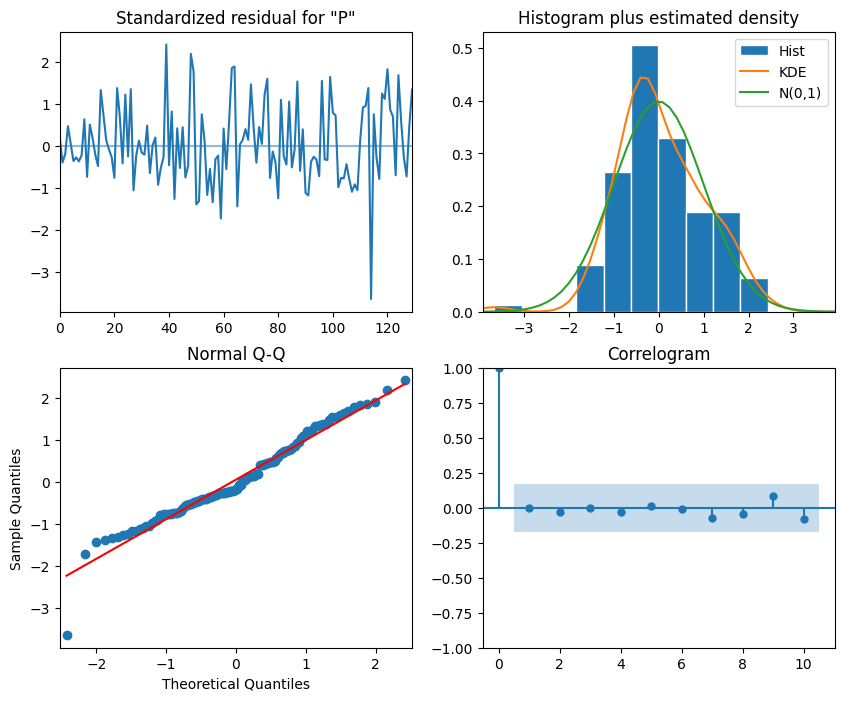

In [16]:
ARIMA_model = SARIMAX(train, order=(11, 2, 3), simple_differencing=False)
ARIMA_model_fit = ARIMA_model.fit(disp=False)
fig = ARIMA_model_fit.plot_diagnostics(figsize=(10, 8))

$ARIMA(11,2,3)$ 模型的残差诊断。在左上图中，残差没有趋势，方差似乎随着时间的推移相当恒定，这类似于白噪声的行为。右上图显示了残差的分布，尽管存在不寻常的峰值，但仍接近正态分布。左下角的 Q-Q 图进一步证实了这一点，该图显示了一条位于 $y = x$ 上的相当直线。最后，右下图中的相关图显示在滞后 0 后没有显着的自相关系数，这与白噪声完全相同。 从该分析来看，残差类似于白噪声。

下一步是对残差运行 Ljung-Box 检验，以确保它们是独立且不相关的。

In [17]:
from statsmodels.stats.diagnostic import acorr_ljungbox

residuals = ARIMA_model_fit.resid
acorr_ljungbox(residuals, np.arange(1, 11, 1))

,lb_stat,lb_pvalue
1,6.548155,0.010499
2,6.674285,0.035538
3,6.947570,0.073588
4,7.744121,0.101414
5,8.388670,0.136076
6,8.676520,0.192604
7,9.493908,0.219112
8,9.731740,0.284361
9,9.741837,0.371786
10,11.529121,0.317805


除前两个值外，返回的 p 值均大于 0.05。这意味着，根据 Ljung-Box 检验，我们拒绝零假设，错误的可能性为 5%，因为我们将显着性边界设置为 0.05。然而，第三个值及以后的值都大于 0.05，因此我们不能拒绝原假设，得出结论：残差从滞后 3 开始不相关。

这是一个值得剖析的有趣情况，因为残差的图形分析使我们得出结论，它们类似于白噪声，但 Ljung-Box 检验指出滞后 1 和 2 处存在某种相关性。这意味着我们的 ARIMA 模型没有捕获所有来自数据的信息。

In [37]:
test = df.iloc[-12:].copy()
test["naive_seasonal"] = df["Passengers"].iloc[120:132].values
ARIMA_pred = ARIMA_model_fit.get_prediction(132, 143).predicted_mean
test["ARIMA_pred"] = ARIMA_pred

### Forecasting with a $SARIMA(p,d,q)(P,D,Q)_m$ model

In [21]:
ad_fuller_result = adfuller(df["Passengers"])
print(f"ADF Statistic: {ad_fuller_result[0]}")
print(f"p-value: {ad_fuller_result[1]}")

ADF Statistic: 0.8153688792060543
p-value: 0.9918802434376411


In [22]:
df_diff = np.diff(df["Passengers"], n=1)
ad_fuller_result = adfuller(df_diff)
print(f"ADF Statistic: {ad_fuller_result[0]}")
print(f"p-value: {ad_fuller_result[1]}")

ADF Statistic: -2.8292668241700034
p-value: 0.05421329028382497


In [23]:
df_diff_seasonal_diff = np.diff(df_diff, n=12)
ad_fuller_result = adfuller(df_diff_seasonal_diff)
print(f"ADF Statistic: {ad_fuller_result[0]}")
print(f"p-value: {ad_fuller_result[1]}")

ADF Statistic: -17.624862360200556
p-value: 3.8230468558474035e-30


![General modeling procedure for the SARIMA model](../img/fig8-11.png)

*General modeling procedure for the SARIMA model*

In [30]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)
SARIMA_order_list = list(product(ps, qs, Ps, Qs))
train = df["Passengers"][:-12]

d = 1
D = 1
s = 12
SARIMA_result_df = optimize_SARIMA(train, SARIMA_order_list, d, D, s)

  0%|          | 0/256 [00:00<?, ?it/s]

d:\anaconda3\envs\fi\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
d:\anaconda3\envs\fi\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
d:\anaconda3\envs\fi\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
d:\anaconda3\envs\fi\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
d:\anaconda3\envs\fi\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  C

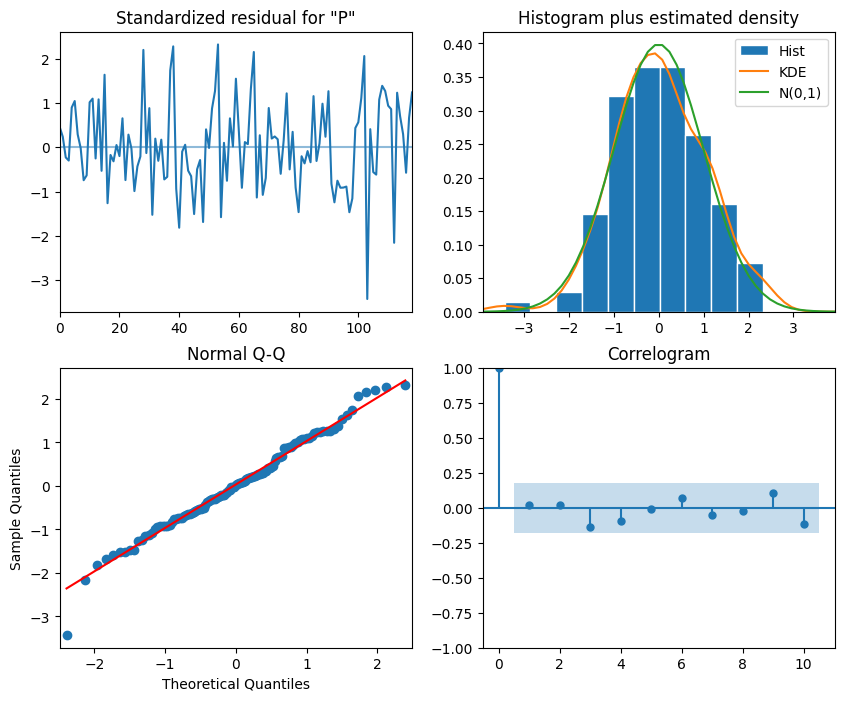

In [34]:
SARIMA_model = SARIMAX(
    train, order=(2, 1, 1), seasonal_order=(1, 1, 2, 12), simple_differencing=False
)
SARIMA_model_fit = SARIMA_model.fit(disp=False)
fig = SARIMA_model_fit.plot_diagnostics(figsize=(10, 8))

In [35]:
residuals = SARIMA_model_fit.resid
lb_result = acorr_ljungbox(residuals, np.arange(1, 11, 1))
print(lb_result)

     lb_stat  lb_pvalue
1   0.004834   0.944570
2   0.746421   0.688520
3   1.023573   0.795548
4   1.228193   0.873435
5   1.437072   0.920215
6   1.713230   0.944095
7   2.310092   0.940706
8   2.721010   0.950628
9   2.737758   0.973791
10  4.972734   0.892992


In [39]:
SARIMA_pred = SARIMA_model_fit.get_prediction(132, 143).predicted_mean
test["SARIMA_pred"] = SARIMA_pred

### Comparing the performance of each forecasting method

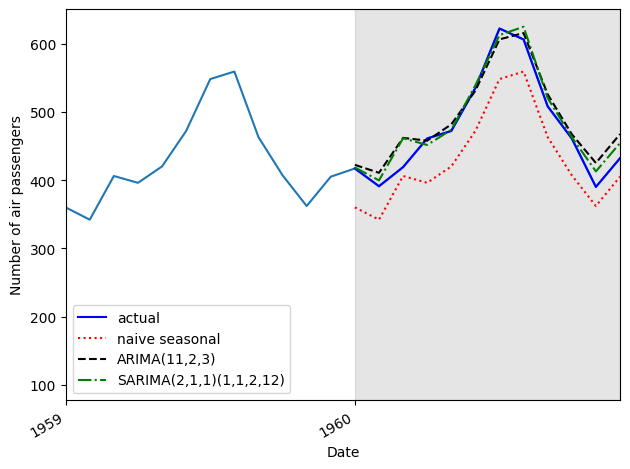

In [40]:
fig, ax = plt.subplots()
ax.plot(df["Month"], df["Passengers"])
ax.plot(test["Passengers"], "b-", label="actual")
ax.plot(test["naive_seasonal"], "r:", label="naive seasonal")
ax.plot(test["ARIMA_pred"], "k--", label="ARIMA(11,2,3)")
ax.plot(test["SARIMA_pred"], "g-.", label="SARIMA(2,1,1)(1,1,2,12)")
ax.set_xlabel("Date")
ax.set_ylabel("Number of air passengers")
ax.axvspan(132, 143, color="#808080", alpha=0.2)
ax.legend()
plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))
ax.set_xlim(120, 143)
fig.autofmt_xdate()
plt.tight_layout()

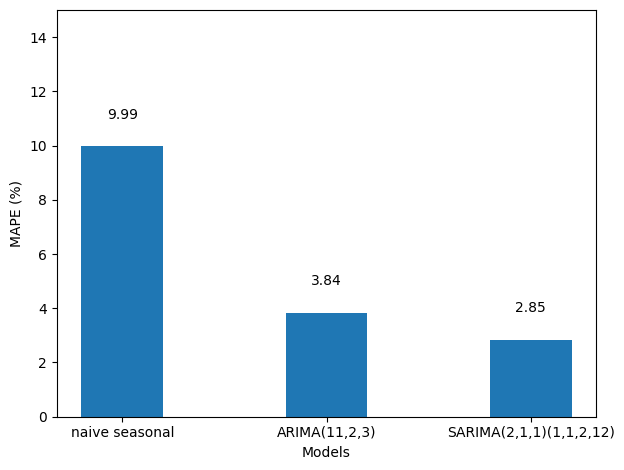

In [42]:
from sklearn.metrics import mean_absolute_percentage_error

mape_naive_seasonal = 100 * mean_absolute_percentage_error(
    test["Passengers"], test["naive_seasonal"]
)
mape_ARIMA = 100 * mean_absolute_percentage_error(
    test["Passengers"], test["ARIMA_pred"]
)
mape_SARIMA = 100 * mean_absolute_percentage_error(
    test["Passengers"], test["SARIMA_pred"]
)
fig, ax = plt.subplots()
x = ["naive seasonal", "ARIMA(11,2,3)", "SARIMA(2,1,1)(1,1,2,12)"]
y = [mape_naive_seasonal, mape_ARIMA, mape_SARIMA]
ax.bar(x, y, width=0.4)
ax.set_xlabel("Models")
ax.set_ylabel("MAPE (%)")
ax.set_ylim(0, 15)
for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value, 2)), ha="center")
plt.tight_layout()

## Next steps

我们慢慢地建立了一个更通用和更复杂的模型，从 $MA(q)$ 和 $AR(p)$ 模型开始，将它们组合成 $ARMA(p,q)$ 模型，从而得到 $ARIMA(p,d,q)$ 模型，最后到 $SARIMA(p,d,q)(P,D,Q)_m$ 模型。这些模型仅考虑时间序列本身的值。 然而，外部变量也可以预测我们的时间序列，这是有道理的。例如，如果我们希望对一个国家随时间变化的总支出进行建模，那么查看利率或债务水平可能是可以预测的。我们如何将这些外部变量包含在模型中？

这将我们引向 $SARIMAX$ 模型。 注意添加了 $X$，它代表外生变量。该模型将结合我们迄今为止学到的所有内容，并通过添加外部变量的影响来预测我们的目标来进一步扩展它。